# Estimate disk scale height, disk radius, and disk mass using plons
following the method described in Sect. 4.4. of Malfait et al. 2024a 
(https://ui.adsabs.harvard.edu/abs/2024arXiv240813158M/abstract)



### Short overview of the method:
To estimate the disk quantities, we integrate over an array of radii (r_array), with step r_step (set to 0.01 au). 

For each radius r_i in this array, we estimate the disk scale height as the median of the scale heights at certain coordinates (r_i,theta_j)

Then using the values of r_i and the median scale height, the added mass w.r.t. to total disk mass of the previous integration step is calculated.

The radius is then defined as the radius where this added mass w.r.t. the total mass is significantly small (see Eq. (9) of Malfait+ 2024a)

Because the disks are asymmetric, we can estimate these quantities in function of radius in different quadrants, to quantify the assymetry of the disk

Therefore, this script contains one function were calculations are performed over the full theta range (fullThetaCalculations()), and one over 4 different theta quadrants (thetaRegionsCalculations())

### Importing packages

In [1]:
%load_ext autoreload  
%autoreload 2

In [2]:
import plons
import os
import numpy                    as np
import matplotlib.pyplot        as plt
# import necessary plons scripts
import plons.ConversionFactors_cgs        as cgs
import plons.GeometricalFunctions         as gf
import plons.AccrDisk                     as ad

### Function to calculate scale height and disk mass ifo radius, using the median scale height in all theta directions



In [3]:
'''
Input:
dumpData             input data, used for density and position
run                  modelName, used to save in correct locations
dump                 dumpNumber, used to save under correct name
xH                   calculate quantities at first or second scale height (see Eq.7 and 8 in Malfait 2024), 
                    '2H' used for disk radius and mass estimates


Output:
r_array             array of radii starting at 'lowerR', ending at estimated disk radius, and increasing with step 'r_step'
SH_array            array of scale height estimates at each radius 
RhoMax_array        array of maximum density value, which is probably at orbital plane, at each radius
totalMassDisk       array of total disk mass assuming that disk radius is r_i of corresponding r_array
rel_mass_added      array of mass added in this r_step, divided by total mass at previous r_i

Note that the surface density and optical depth values have not been in used in our paper, mainly because it is a too approximate approach
Sigma_array         array of estimated surface density Sigma
SigmaTheor_array    array of theoretical surface density Sigma
Tau_array           array of estimated optical depth tau
TauTheor_array      array of theoretical optical depth tau

! The output data is saved in a txt file, and can be used to produce plots using the accrDisks_plotsHRM_Plons.ipynb notebook
'''
def fullThetaCalculations(dumpData,run,dump,xH, printOut = False):
    # Choose which and how many r and theta values you want to use to calculate scale heights and disk mass and for plot of rho vs h
    n_grid         = 10000
    maxH           = 1.5 *cgs.au

    numberOfThetas = 10
    thetaMin       = 0
    thetaMax       = 2*np.pi
    thetaArray     = np.linspace(thetaMin,(numberOfThetas-1)/numberOfThetas*thetaMax,numberOfThetas)

    crit           = 0.3       #smalles constant in our case towards which the relative added mass ocnsistently keeps decreasing for all models
    lowerR         = 0.02
    r_step         = 0.01

    # Calculate arrays with radii, disk mass, relative addes mass, and scale heights
    r_array,totalMassDisk,rel_mass_added,SH_array,RhoMax_array,Sigma_array,SigmaTheor_array,Tau_array,TauTheor_array =  ad.get_SH_diskMass_radius(lowerR,r_step,thetaArray,dumpData,maxH,n_grid,run,crit,xH,phiQuadr = False, printOut = printOut)
    
    '''
    Write data for full theta region in txt file infoAccrDisk_wind_00....txt
    '''
    testLimit = crit
    # make directory to save results in
    wdir = os.path.join(run,'plotsAnalysis')
    !mkdir -p $wdir
    # construct txt file with calculated arrays of data
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_wind_00'+str(dump)+'_'+xH+'.txt')
    with open (title,'w') as f:
        f.write('Model '+str(run)+'wind_00'+str(dump)+'\n')
        f.write('Data analysis accretion disks')
        f.write('\n')
        f.write('\n')    
        f.write('for rstep '+ str(r_step)+ ' au (=racc) and limit of '+ str(testLimit)+':'+'\n')
        f.write('the estimated radius is:           '+ str(np.round(r_array[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.au,3))+' au'+'\n')
        f.write('the estimated total mass is:       '+ str(np.round(totalMassDisk[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.Msun,11))+' Msun'+'\n')
        f.write('the estimated max scale height is: '+ str(np.round(SH_array[np.where(rel_mass_added/r_step<testLimit)][0]/cgs.au,3))+' au'+'\n')
        f.write('\n')
        f.write('\n')
        f.write('for rstep '+ str(r_step)+ ' au (=racc):'+'\n')
        names = ['r [au]', 'SH [au]', 'Rho_max [g/cm^3]','Mtot [Msun]', 'Mrel/rstep []', 'Sigma []','Sigma Theor []','OptDepth []','OptDepthTheor []']
        f.write("{: <30} {: <30} {: <30} {: <30} {: <30} {: <30} {: <30} {: <30} {: <30}".format(*names))
        col_format = "{:<31}" * 9 + "\n"   # 5 left-justfied columns with 15 character width
        f.write('\n')
        for i in zip(np.round(r_array/cgs.au,2),np.round(SH_array/cgs.au,4),np.round(RhoMax_array,16),np.round(totalMassDisk/cgs.Msun,13),np.round(rel_mass_added/r_step,3),np.round(Sigma_array,4),np.round(SigmaTheor_array,4),np.round(Tau_array,3),np.round(TauTheor_array,3)):
            f.write(col_format.format(*i))

    '''
    If you want, you can immediately construct some plots here:
    Make plots of relative added mass, total disk mass, midplane rho, and scale heights ifo r
    '''
    if xH == '1H':
        fig, axs = plt.subplots(nrows = 1, ncols= 6 , figsize=(35, 5))
    else:
        fig, axs = plt.subplots(nrows = 1, ncols= 3 , figsize=(14, 5))
    ad.plot_relAddedMass(axs[0], r_array,rel_mass_added,r_step,crit)
    ad.plot_totalDiskMass(axs[1], r_array,totalMassDisk)
    ad.plot_scaleHeights(axs[2], r_array,SH_array)
    if xH == '1H':
        ad.plot_surfDensity(axs[3],r_array,Sigma_array,SigmaTheor_array)
        ad.plot_opticalDepth(axs[4],r_array,Tau_array,TauTheor_array)
        ad.plot_rhoMax(axs[5],r_array,RhoMax_array)
    
    return fig

### Function to calculate scale height and disk mass ifo radius, using the median scale height in different theta quadrants

In [4]:
'''
Same function as before, but in 4 different theta quadrants
Saves data in 4 seperate txt files

input
dumpData             input data, used for density and position
run                  modelName, used to save in correct locations
dump                 dumpNumber, used to save under correct name
xH                   calculate quantities at first or second scale height (see Eq.7 and 8 in Malfait 2024)
                     '2H' used for disk radius and mass estimates
'''

def thetaRegionsCalculations(dumpData,run,dump,xH):
    '''
    Calculations of scale height, mass estimates, radius
    For 4 different theta regions
    '''

    # Choose which and how many r and theta values you want to use to calculate scale heights and disk mass and for plot of rho vs h
    n_grid         = 10000
    # maxH           = 1.5 * cgs.au    
    maxH           = 3 * cgs.au    
    numberOfThetas = 10        #Number of thetas withing one array 
    
    '''
    Divide into 4 different theta regions
    '''
    # Away from AGB
    thetaMin1      = -1./4. *np.pi
    thetaMax1      = 1./4. *np.pi
    thetaArray1    = np.linspace(thetaMin1,thetaMax1,numberOfThetas)
    # Make sure all theta's are positive
    i = 0
    for theta in thetaArray1:
        if theta < 0:
            thetaArray1[i] = thetaArray1[i]+2*np.pi
        i = i+1

    # Positive y --> bow shock side (in front of companion)
    thetaMin2      = 1./4. * np.pi
    thetaMax2      = 3./4. * np.pi
    thetaArray2    = np.linspace(thetaMin2,thetaMax2,numberOfThetas) 

    # Towards AGB 
    thetaMin3      = 3./4. * np.pi
    thetaMax3      = 5./4. * np.pi
    thetaArray3    = np.linspace(thetaMin3,thetaMax3,numberOfThetas) 

    # Negative y --> flow behind companion
    thetaMin4      = 5./4. * np.pi
    thetaMax4      = 7./4. * np.pi
    thetaArray4    = np.linspace(thetaMin4,thetaMax4,numberOfThetas)

    crit           = 0.3
    
    lowerR         = 0.02
    # sometimes you will see that you need to vary the step a little bit to make sure the algorithm does not get stuck in the first radii steps
    r_step1         = 0.01
    r_step2        = r_step1
    r_step3        = r_step1
    r_step4        = r_step1
    
    '''
    Calculate scale heights and mass estimates at each r; and estimate final radius
    Make text files with important info to make plots 
    for different theta regimes
    '''
    testLimit = crit
    # calculate scale height and mass estimates at each r for this setup
    r_array1,totalMassDisk1,rel_mass_added1,SH_array1,RhoMax_array1,Sigma_array1,SigmaTheor_array1,Tau_array1,TauTheor_array1 =  ad.get_SH_diskMass_radius(lowerR,r_step1,thetaArray1,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True,printOut=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~0_wind_00'+str(dump)+'_'+xH+'.txt')
    ad.writeFile(title,r_step1,testLimit,r_array1,rel_mass_added1,totalMassDisk1,SH_array1,RhoMax_array1,Sigma_array1,SigmaTheor_array1,Tau_array1,TauTheor_array1)
    
    r_array2,totalMassDisk2,rel_mass_added2,SH_array2,RhoMax_array2,Sigma_array2,SigmaTheor_array2,Tau_array2,TauTheor_array2 =  ad.get_SH_diskMass_radius(lowerR,r_step2,thetaArray2,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True,printOut=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~pi:2_wind_00'+str(dump)+'_'+xH+'.txt')
    ad.writeFile(title,r_step2,testLimit,r_array2,rel_mass_added2,totalMassDisk2,SH_array2,RhoMax_array2,Sigma_array2,SigmaTheor_array2,Tau_array2,TauTheor_array2)

    r_array3,totalMassDisk3,rel_mass_added3,SH_array3,RhoMax_array3,Sigma_array3,SigmaTheor_array3,Tau_array3,TauTheor_array3 =  ad.get_SH_diskMass_radius(lowerR,r_step3,thetaArray3,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True,printOut=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~pi_wind_00'+str(dump)+'_'+xH+'.txt')
    ad.writeFile(title,r_step3,testLimit,r_array3,rel_mass_added3,totalMassDisk3,SH_array3,RhoMax_array3,Sigma_array3,SigmaTheor_array3,Tau_array3,TauTheor_array3)

    r_array4,totalMassDisk4,rel_mass_added4,SH_array4,RhoMax_array4,Sigma_array4,SigmaTheor_array4,Tau_array4,TauTheor_array4 =  ad.get_SH_diskMass_radius(lowerR,r_step1,thetaArray4,dumpData,maxH,n_grid,run,crit,xH,phiQuadr=True,printOut=True)
    title = os.path.join(run,'plotsAnalysis/infoAccrDisk_theta~pi3:2_wind_00'+str(dump)+'_'+xH+'.txt')
    ad.writeFile(title,r_step4,testLimit,r_array4,rel_mass_added4,totalMassDisk4,SH_array4,RhoMax_array4,Sigma_array4,SigmaTheor_array4,Tau_array4,TauTheor_array4)
    
    
    '''
    If you want you can already construct some plots to see the results
    '''
    if xH == '1H':
        fig, axs = plt.subplots(nrows = 1, ncols= 6 , figsize=(35, 5))
    else:
        fig, axs = plt.subplots(nrows = 1, ncols= 3 , figsize=(14, 5))
        
    ad.plot_relAddedMass_4theta(axs[0],r_array1,r_array2,r_array3,r_array4,rel_mass_added1,rel_mass_added2,rel_mass_added3,rel_mass_added4,r_step1,r_step3,crit)
    ad.plot_totalDiskMass_4theta(axs[1],r_array1,r_array2,r_array3,r_array4,totalMassDisk1,totalMassDisk2,totalMassDisk3,totalMassDisk4)
    ad.plot_scaleHeights_4theta(axs[2],r_array1,r_array2,r_array3,r_array4,SH_array1,SH_array2,SH_array3,SH_array4)
    if xH == '1H':
        ad.plot_surfDensity_4theta(axs[3],r_array1,r_array2,r_array3,r_array4,Sigma_array1,Sigma_array2,Sigma_array3,Sigma_array4)
        ad.plot_opticalDepth_4theta(axs[4],r_array1,r_array2,r_array3,r_array4,Tau_array1,Tau_array2,Tau_array3,Tau_array4)
        ad.plot_rhoMax_4theta(axs[5], r_array1,r_array2,r_array3,r_array4,RhoMax_array1,RhoMax_array2,RhoMax_array3,RhoMax_array4)
    return fig

### Main function for the actual calculations

In [ ]:
'''
input:
run                  modelName, used to save in correct locations
dump                 dumpNumber, used to save under correct name
scaleHeightList      list with 1H, 2H or one of both, to know for which scale height calculations need to be done
full, quadrants      boolians to know if calculations should be done for full thetaregion and/or quadrants
'''

def main(run,dump,scaleHeightList,full=True,quadrants=True,printOut = False):
    '''
    Load in data
    '''    
    setup = plons.LoadSetup(run, "wind")
    dumpData = plons.LoadFullDump(os.path.join(run, f"wind_%05d" % dump), setup)
    
    # Coordinate transformation: translation to rcomp + rotation such that AGB is on positive x-axis
    # Coordinate transformation such that comp is at (0,0) and AGB at -x
    dumpData['x'],dumpData['y'],dumpData['r'] = ad.calc_new_position(dumpData['x'],dumpData['y'],dumpData)
    phi = gf.calcPhi(dumpData['x'],dumpData['y'])
    # print(phi)
    dumpData['Phi'] = np.where(phi < 0, phi + 2 * np.pi, phi)
    
    '''
    You can use this to test if coordinate transformation is correct
    '''   
    # testPositionAndTheta(dumpData,run,dump)

    '''
    Perform calculations for full theta region and/or 4 different theta regions
    make plots and write txt files with results
    '''  
    for xH in scaleHeightList:
        if full==True:
            if printOut: print('Calculations full theta region:')
            fig = fullThetaCalculations(dumpData,run,dump,xH, printOut)
            fig.savefig(run+'plotsAnalysis/Disk_wind_%05d'%(dump)+'_'+xH+'.png', bbox_inches='tight')
        if quadrants==True:
            if printOut: print('Calculations for different theta regions:')
            fig = thetaRegionsCalculations(dumpData,run,dump,xH)
            fig.savefig(run+f'plotsAnalysis/Theta_rstep_wind_%05d'%(dump)+'_'+xH+'.png', bbox_inches='tight')

### Examples

Calculations full theta region:
---------
r 0.02  au
scale height is  0.011401140114011388
mass added [Msun]:  3.4540161426105943e-11
relMass_added/rstep (rico) =  100.0
---------
r 0.03  au


/home/matse/codes/anaconda3/envs/plons/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matse/codes/anaconda3/envs/plons/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


scale height is  0.009450945094509448
mass added [Msun]:  1.554307264174767e-10
relMass_added/rstep (rico) =  81.818
---------
r 0.04  au
scale height is  0.009000900090009034
mass added [Msun]:  5.200213192485949e-10
relMass_added/rstep (rico) =  73.243
---------
r 0.05  au
scale height is  0.008025802580258031
mass added [Msun]:  8.980441970787545e-10
relMass_added/rstep (rico) =  55.847
---------
r 0.06  au
scale height is  0.008475847584758509
mass added [Msun]:  1.3604985806171728e-09
relMass_added/rstep (rico) =  45.831
---------
r 0.07  au
scale height is  0.010201020102010244
mass added [Msun]:  1.780737211301462e-09
relMass_added/rstep (rico) =  37.495
---------
r 0.08  au
scale height is  0.0118511851185118
mass added [Msun]:  2.1837057612726974e-09
relMass_added/rstep (rico) =  31.497
---------
r 0.09  au
scale height is  0.012976297629762962
mass added [Msun]:  2.477297133394598e-09
relMass_added/rstep (rico) =  26.325
---------
r 0.1  au
scale height is  0.0150765076507650

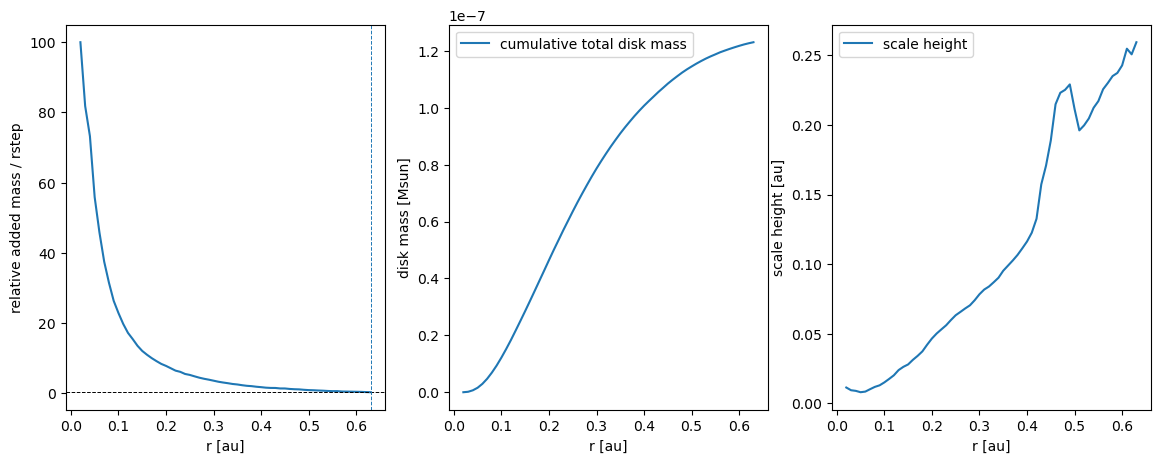

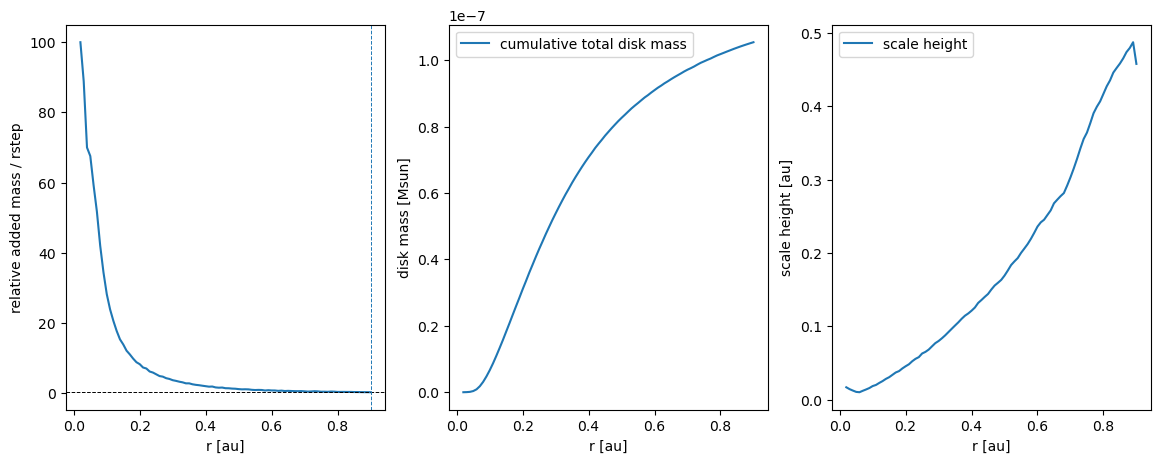

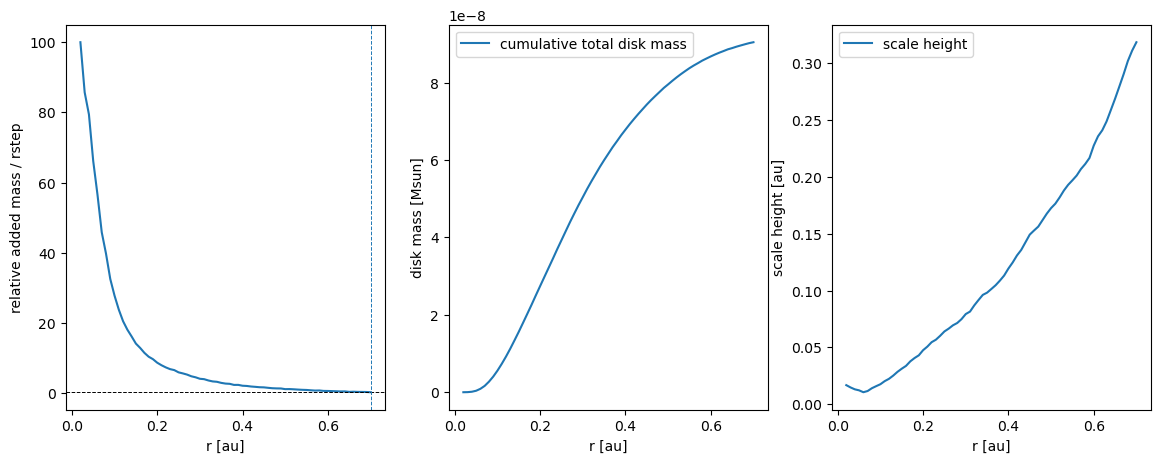

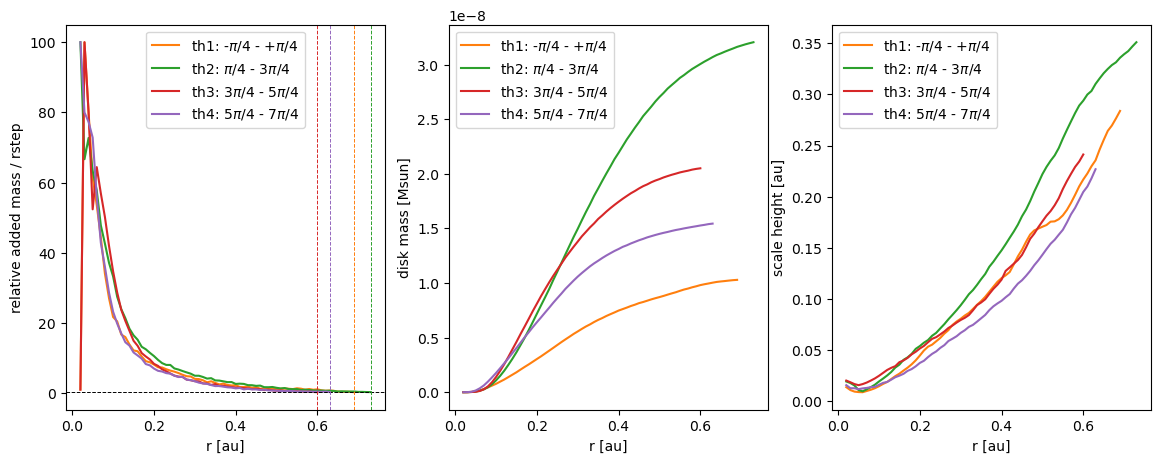

In [6]:
'''
Examples, 2 models, different dumps for the eccentric, different quadrants
for the circular one
'''
model  = 'model-v10e50_AD/'
!mkdir -p $model
infile = os.path.join(model, f"wind.in")
if not os.path.exists(infile):
    !wget -q "https://raw.githubusercontent.com/Ensor-code/phantom-models/refs/heads/main/Malfait%2B2024a/v10e50_AD/wind.in" --output-document $infile
setupfile = os.path.join(model, f"wind.setup")
if not os.path.exists(setupfile):
    !wget -q "https://raw.githubusercontent.com/Ensor-code/phantom-models/refs/heads/main/Malfait%2B2024a/v10e50_AD/wind.setup" --output-document $setupfile
dumps  = [555,584]
for dumpnumber in dumps:
    dump = os.path.join(model, f"wind_{dumpnumber:05d}")
    if not os.path.exists(dump):
        wgetlink = f"https://github.com/Ensor-code/phantom-models/raw/refs/heads/main/Malfait+2024a/v10e50_AD/wind_{dumpnumber:05d}?download="
        !wget -q $wgetlink --output-document $dump
    main(model,dumpnumber,['2H'],full=True,quadrants=False,printOut=True)

model  = 'model-v10e00_AD/'
!mkdir -p $model
infile = os.path.join(model, f"wind.in")
if not os.path.exists(infile):
    !wget -q "https://raw.githubusercontent.com/Ensor-code/phantom-models/refs/heads/main/Malfait%2B2024a/v10e00_AD/wind.in" --output-document $infile
setupfile = os.path.join(model, f"wind.setup")
if not os.path.exists(setupfile):
    !wget -q "https://raw.githubusercontent.com/Ensor-code/phantom-models/refs/heads/main/Malfait%2B2024a/v10e00_AD/wind.setup" --output-document $setupfile
dumpnumber   = 584
dump = os.path.join(model, f"wind_{dumpnumber:05d}")
if not os.path.exists(dump):
    wgetlink = f"https://github.com/Ensor-code/phantom-models/raw/refs/heads/main/Malfait+2024a/v10e00_AD/wind_{dumpnumber:05d}?download="
    !wget -q $wgetlink --output-document $dump
main(model,dumpnumber,['2H'],full=True,quadrants=True,printOut=True)


### Other possibilities:
- Do calculations for different dumps throughout simulation to see how disk mass evolves
- Do calculations for different dumps within one eccentric orbit to see how disk properties change depending on orbital phase
- If you want something else, check if there is not yet a function for it in AccrDisk.py in the source code